In [ ]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.ndimage import convolve

In [2]:
p = lambda x: 3*(x**2) - 2*x
q = lambda x: 6*(x**3) + 3 + 1
f = lambda x: p(x)/q(x)

# f = lambda x: np.tan(x)

f = lambda x: np.sin(x)

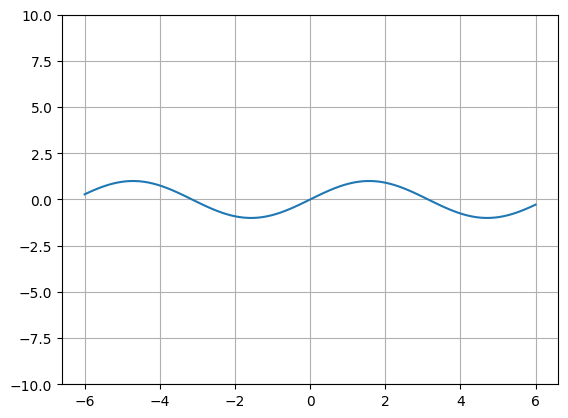

In [3]:
x = np.linspace(-6, 6, 100)
y = f(x)
plt.plot(x, y)
plt.ylim(-10, 10)
plt.grid()

### Latest

In [4]:
import numpy as np
import itertools
from scipy.ndimage import convolve
from math import floor, ceil
from dataclasses import dataclass
from scipy import optimize

def take_slice(a, slice_ind, axis):
    return a[(*(slice(None), )*axis, slice_ind, *(slice(None), )*(a.ndim - axis - 1))]

def _get_degrees(deg):
    '''return array of monomial powers with deg as highest degree(s)
    deg: int or tuple.
        If deg is an int, the function returns the 1D monomial powers: [0, ..., deg]
        If deg is a tuple (d1, .., dn) the function returns all set product
        combinations of [0, ..., d1] x [0, ..., d2] x ... x [0, ..., dn]
        This way, all combinations of (x1**i1), (x2**i2), ..., (xn**in) can be represented.
        '''
    if type(deg) == int:
        return np.arange(deg + 1)
    else:
        return np.array(list(itertools.product(*(range(d + 1) for d in deg))))

def _as_vector(x):
    _x = np.asarray(x)
    if len(_x.shape) == 1:
        _x = _x.reshape(-1, 1)
    return _x

def _vandermonde(x, degrees):
    _x = _as_vector(x)
    return np.stack(np.prod([_x**d for d in degrees], axis=-1), axis=-1)

def _trim_coef(coef):
    out = np.asarray(coef)
    if len(out) == 0:
        return out
    else:
        for axis, s in enumerate(out.shape):
            for i in range(s-1, -1, -1):
                if np.any(np.take(out, i, axis=axis) != 0):
                    break
            out = take_slice(out, slice(i+1), axis=axis)
        return out

def polyadd_ND(f_coef, g_coef):
    f_coef_pad = np.pad(f_coef, [(0, max(sg - sf, 0)) for (sf, sg) in zip(f_coef.shape, g_coef.shape)], mode='constant', constant_values=0)
    g_coef_pad = np.pad(g_coef, [(0, max(sf - sg, 0)) for (sf, sg) in zip(f_coef.shape, g_coef.shape)], mode='constant', constant_values=0)
    return NDPolynomial(f_coef_pad + g_coef_pad)

def polymul_ND(f_coef, g_coef):
    if len(f_coef) == 0 or len(g_coef) == 0:
        return NDPolynomial([])
    
    f_coef_pad = np.pad(f_coef, [(ceil((s-1)/2), floor((s-1)/2)) for s in g_coef.shape], mode='constant', constant_values=0)
    return NDPolynomial(convolve(f_coef_pad, g_coef, mode='constant', cval=0.0))

@dataclass
class NDPolynomial:
    '''Class for representing a polynomial function of multiple variables
    coef: numpy.ndarray of shape (d1, d2, ..., dn) where d· are the highest degrees and n is the number of variables the function f(x1, x2, ..., xn) takes.
        the coef matrix should be formatted such that
        f(x1, x2, ..., xn) = coef[i1, i2, ..., in] (x1 ** i1) * ... (x1 ** in)
        where there is implicit sumation over i1, ..., in (e.g. the first sum has i1 going from 0 to di1)
    '''
    coef: np.ndarray

    def __init__(self, coef):
        self.coef = _trim_coef(coef)

    def get_degrees(self):
        return _get_degrees(deg=np.array(self.coef.shape) - 1)

    def __call__(self, x):
        _x = _as_vector(x)
        if len(self.coef) > 0:
            degrees = self.get_degrees()
            return _vandermonde(_x, degrees) @ self.coef.flatten()
        else:
            return np.zeros_like(_x)
    
    def __add__(self, g):
        return polyadd_ND(self.coef, g.coef)
    
    def __sub__(self, g):
        return polyadd_ND(self.coef, -g.coef)
    
    def __mul__(self, g):
        return polymul_ND(self.coef, g.coef)

    def _diff(self, axis):
        axis_deg = self.coef.shape[axis] - 1
        deriv_coef = np.arange(1, axis_deg + 1) * take_slice(self.coef, slice(1, None), axis=axis)
        return NDPolynomial(deriv_coef)

    def deriv(self, axis, order=1):
        deriv = self
        for i in range(order):
            if len(deriv.coef) == 0:
                break
            deriv = deriv._diff(axis=axis)
        return deriv

# def polyadd_ND(f: NDPolynomial, g: NDPolynomial):
#     f_coef_pad = np.pad(f.coef, [(0, max(sg - sf, 0)) for (sf, sg) in zip(f.coef.shape, g.coef.shape)], mode='constant', constant_values=0)
#     g_coef_pad = np.pad(g.coef, [(0, max(sf - sg, 0)) for (sf, sg) in zip(f.coef.shape, g.coef.shape)], mode='constant', constant_values=0)
#     return NDPolynomial(f_coef_pad + g_coef_pad)

# def polymul_ND(f: NDPolynomial, g: NDPolynomial):
#     f_coef_pad = np.pad(f.coef, [(ceil((s-1)/2), floor((s-1)/2)) for s in g.coef.shape], mode='constant', constant_values=0)
#     return NDPolynomial(convolve(f_coef_pad, g.coef, mode='constant', cval=0.0))

@dataclass
class RationalFunction:
    '''Class for representing a rational function, i.e. a function which is the ratio of two polynomials:
    f(x) = P_L(x)/P_M(x)
    coef_L: np.ndarray, nominator coefficients
    coef_M: np.ndarray, denominator coefficients
    '''
    coef_L: np.ndarray
    coef_M: np.ndarray

    def __init__(self, coef_L, coef_M):
        assert len(coef_M) > 0, "Can't divide by 0. len of denominator's coef_M must be greater than 0 to represent a nonzero polynomial."
        self.coef_L = coef_L
        self.coef_M = coef_M

    def __call__(self, x):
        return NDPolynomial(self.coef_L)(x) / NDPolynomial(self.coef_M)(x)
    
    def _diff(self, axis):
        P_L = NDPolynomial(self.coef_L)
        P_M = NDPolynomial(self.coef_M)
        deriv_coef_L = (P_L._diff(axis) * P_M - P_L * P_M._diff(axis)).coef
        deriv_coef_M = (P_M * P_M).coef
        return  RationalFunction(deriv_coef_L, deriv_coef_M)
    
    def deriv(self, axis, order=1):
        deriv = self
        for i in range(order):
            if len(deriv.coef_L) == 0:
                break
            deriv = deriv._diff(axis=axis)
        return deriv

def deg_as_array(deg, dims):
    if type(deg) == int:
        _deg = np.array([deg]*dims)
    else:
        _deg = np.asarray(deg)
    return _deg

def fit_polynomial(x, y, deg, exclude_degrees=[]):
    '''Returns NDPolynomial fit of x, y data.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    deg: int or tuple
        If deg is an int, the highest degree of x1, ..., xM will all be deg.
        If deg is a tuple (d1, .., dM), it corresponds to the highest degrees of x1, ..., xM.
    '''
    _x = _as_vector(x)
    _y = _as_vector(y)

    _deg = deg_as_array(deg, dims=_x.shape[-1])
    assert len(_deg) == _x.shape[-1], "length of degrees, deg, must match number of features in x"
    degrees = _get_degrees(_deg)
    monomials = _vandermonde(_x, degrees)
    coef_shape = tuple(np.array(_deg) + 1)
    coef = np.zeros(coef_shape)

    _exclude_degrees = [(d, ) if type(d) == int else tuple(d) for d in exclude_degrees]
    assert np.all([len(d) == len(_deg) for d in _exclude_degrees]), 'exclude_degrees does not match number of dimensions'
    include = np.array([tuple(d) not in _exclude_degrees for d in degrees])
    coef[include.reshape(coef_shape)] = np.linalg.lstsq(monomials[:, include], _y, rcond=None)[0].squeeze()
    
    return NDPolynomial(coef)

def optimize_rational_func(x, y, coef_L0, coef_M0, deg_L, deg_M):
    # If we also wish to do a non-linear optimization afterwards, this is also possible:
    L_shape = tuple(deg_L + 1)
    M_shape = tuple(deg_M + 1)

    def collect_coef(coef_L, coef_M):
        return np.concatenate([coef_L, coef_M])
    
    def unpack_coef(coef):
        coef_L = coef[:np.prod(deg_L + 1)]
        coef_M = coef[np.prod(deg_L + 1):]
        return coef_L, coef_M
    
    def model(x, *vargs):
        coef = np.concatenate([vargs])
        coef_L, coef_M = unpack_coef(coef)
        return RationalFunction(coef_L.reshape(L_shape), coef_M.reshape(M_shape))(x)

    coef = optimize.curve_fit(model, x, y, p0=collect_coef(coef_L0, coef_M0))[0]
    coef_L, coef_M = unpack_coef(coef)
    return coef_L, coef_M

def fit_rational_func(x, y, L, M, optimize=True):
    '''Returns RationalFunction fit of x, y data on the form f(x) = P_L(x)/Q_M(x)
    where P_L is a polynomial of order L and Q_M is of order M.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    L: `int` or `tuple`. Nominator degrees
    M: `int` or `tuple`. Denominator degrees
        If L and M are integers, they are taken to be the highest degree
        in the nominator and denominator polynomial respectively.
        If L and M are tuples, the polynomials assume to take multidimensional inputs 
        and a monomial basis for each polynomial is generated automatically.
        The 0th order coefficient of Q_M is always taken to be 1.
    '''
    _x = _as_vector(x)
    _y = _as_vector(y)

    _deg_L = deg_as_array(L, _x.shape[-1])
    _deg_M = deg_as_array(M, _x.shape[-1])
    assert len(_deg_L) == _x.shape[-1], "length of degrees, deg_L, must match number of features in x"
    assert len(_deg_M) == _x.shape[-1], "length of degrees, deg_M, must match number of features in x"

    degrees_L = _get_degrees(_deg_L)
    degrees_M = _get_degrees(_deg_M)
    VL = _vandermonde(_x, degrees_L)
    VM = _vandermonde(_x, degrees_M)
    W = np.concatenate([VL, - _y * VM[:, 1:]], axis=1)
    coef_LM = np.linalg.lstsq(W, y, rcond=None)[0]
    coef_L = coef_LM[:np.prod(_deg_L + 1)]
    coef_M = np.concatenate([np.array([1]), coef_LM[np.prod(_deg_L + 1):]])
    
    L_shape = tuple(_deg_L + 1)
    M_shape = tuple(_deg_M + 1)

    if optimize:
        coef_L, coef_M = optimize_rational_func(x, y, coef_L, coef_M, _deg_L, _deg_M)

    return RationalFunction(coef_L.reshape(L_shape), coef_M.reshape(M_shape))

In [12]:
deg = (3, 2)
_x = _as_vector(x)
_y = _as_vector(y)

_deg = deg_as_array(deg, dims=_x.shape[-1])
degrees = _get_degrees(_deg)
monomials = _vandermonde(x, degrees)
coef_shape = tuple(np.array(_deg) + 1)
coef = np.zeros(coef_shape)

exclude_degrees = [(0, 0), (1, 0)]
_exclude_degrees = [(d, ) if type(d) == int else tuple(d) for d in exclude_degrees]
assert np.all([len(d) == len(_deg) for d in _exclude_degrees]), 'exclude_degrees does not match number of dimensions'
include = np.array([tuple(d) not in _exclude_degrees for d in degrees])
coef[include.reshape(coef_shape)] = np.linalg.lstsq(monomials[:, include], _y, rcond=None)[0].squeeze()

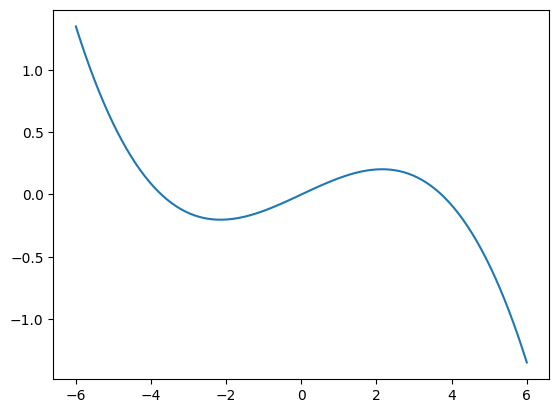

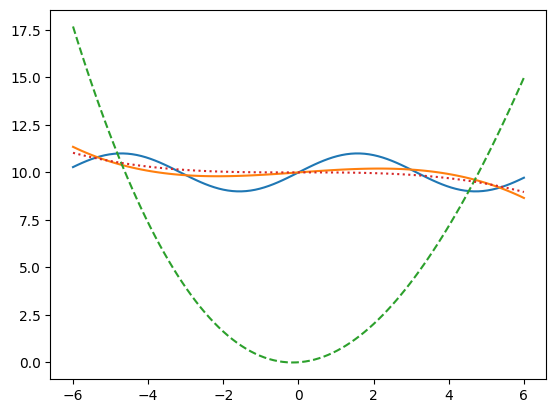

In [15]:
plt.plot(x, y+10)
plt.plot(x, fit_polynomial(x, y+10, deg=3)(x))
plt.plot(x, fit_polynomial(x, y+10, deg=3, exclude_degrees=[0])(x), '--')
plt.plot(x, fit_polynomial(x, y+10, deg=3, exclude_degrees=[1])(x), ':')

### Older Versions

In [171]:
L = 6

def get_degrees(deg, dims=1):
    return np.array(list(itertools.product(*(range(deg + 1), )*dims)))

def vandermonde(x, degrees):
    _x = np.asarray(x)
    if len(_x.shape) == 1:
        _x = _x.reshape(-1, 1)
    return np.stack(np.prod(np.array([_x**d for d in degrees]), axis=-1), axis=-1)

vandermonde(x, get_degrees(L)).shape

(100, 7)

In [172]:
# # If we also wish to do a non-linear optimization afterwards, this is also possible:
# from scipy import optimize
# def model(x, *vargs):
#     coeff = np.concatenate([vargs])
#     return (vandermonde(x, get_degrees(L)) @ coeff[:L+1])/(vandermonde(x, get_degrees(M)) @ coeff[L+1:])
# optimize.curve_fit(model, x, y, p0=np.concatenate([L_coeff, M_coeff]))

In [173]:
# plt.plot(x, y, 'k-')
# plt.plot(x, (VL @ L_coeff)/(VM @ M_coeff), '--')
# plt.ylim(-10, 10)

In [195]:
from math import floor, ceil
from dataclasses import dataclass

# Utility functions
# def np_inner_product(a, b):
#     return np.einsum('...i,...i->...', a, b)

# def np_transpose(A):
#     '''return transpose of only the last two dimensions.'''
#     return np.moveaxis(A, -1, -2)

def take_slice(a, slice_ind, axis):
    return a[(*(slice(None), )*axis, slice_ind, *(slice(None), )*(a.ndim - axis - 1))]

def _get_degrees(deg):
    '''return array of monomial powers with deg as highest degree(s)
    deg: int or tuple.
        If deg is an int, the function returns the 1D monomial powers: [0, ..., deg]
        If deg is a tuple (d1, .., dn) the function returns all set product
        combinations of [0, ..., d1] x [0, ..., d2] x ... x [0, ..., dn]
        This way, all combinations of (x1**i1), (x2**i2), ..., (xn**in) can be represented.
        '''
    if type(deg) == int:
        return np.arange(deg + 1)
    else:
        return np.array(list(itertools.product(*(range(d + 1) for d in deg))))

def _as_vector(x):
    _x = np.asarray(x)
    if len(_x.shape) == 1:
        _x = _x.reshape(-1, 1)
    return _x

def _vandermonde(x, degrees):
    _x = _as_vector(x)
    return np.stack(np.prod([_x**d for d in degrees], axis=-1), axis=-1)

def _trim_coef(coef):
    out = np.asarray(coef)
    if len(out) == 0:
        return out
    else:
        for axis, s in enumerate(out.shape):
            for i in range(s-1, -1, -1):
                if np.any(np.take(out, i, axis=axis) != 0):
                    break
            out = take_slice(out, slice(i+1), axis=axis)
        return out

def polyadd_ND(f_coef, g_coef):
    f_coef_pad = np.pad(f_coef, [(0, max(sg - sf, 0)) for (sf, sg) in zip(f_coef.shape, g_coef.shape)], mode='constant', constant_values=0)
    g_coef_pad = np.pad(g_coef, [(0, max(sf - sg, 0)) for (sf, sg) in zip(f_coef.shape, g_coef.shape)], mode='constant', constant_values=0)
    return NDPolynomial(f_coef_pad + g_coef_pad)

def polymul_ND(f_coef, g_coef):
    f_coef_pad = np.pad(f_coef, [(ceil((s-1)/2), floor((s-1)/2)) for s in g_coef.shape], mode='constant', constant_values=0)
    return NDPolynomial(convolve(f_coef_pad, g_coef, mode='constant', cval=0.0))

@dataclass
class NDPolynomial:
    '''Class for representing a polynomial function of multiple variables
    coef: numpy.ndarray of shape (d1, d2, ..., dn) where d· are the highest degrees and n is the number of variables the function f(x1, x2, ..., xn) takes.
        the coef matrix should be formatted such that
        f(x1, x2, ..., xn) = coef[i1, i2, ..., in] (x1 ** i1) * ... (x1 ** in)
        where there is implicit sumation over i1, ..., in (e.g. the first sum has i1 going from 0 to di1)
    '''
    coef: np.ndarray

    def __init__(self, coef):
        self.coef = _trim_coef(coef)

    def get_degrees(self):
        return _get_degrees(deg=np.array(self.coef.shape) - 1)

    def __call__(self, x):
        _x = _as_vector(x)
        if len(self.coef) > 0:
            degrees = self.get_degrees()
            return _vandermonde(_x, degrees) @ self.coef.flatten()
        else:
            return np.zeros_like(_x)
    
    def __add__(self, g):
        return polyadd_ND(self.coef, g.coef)
    
    def __sub__(self, g):
        return polyadd_ND(self.coef, -g.coef)
    
    def __mul__(self, g):
        return polymul_ND(self.coef, g.coef)

    def _diff(self, axis):
        axis_deg = self.coef.shape[axis] - 1
        deriv_coef = np.arange(1, axis_deg + 1) * take_slice(self.coef, slice(1, None), axis=axis)
        return NDPolynomial(deriv_coef)

    def deriv(self, axis, order=1):
        deriv = self
        for i in range(order):
            if len(deriv.coef) == 0:
                break
            deriv = deriv._diff(axis=axis)
        return deriv

# def polyadd_ND(f: NDPolynomial, g: NDPolynomial):
#     f_coef_pad = np.pad(f.coef, [(0, max(sg - sf, 0)) for (sf, sg) in zip(f.coef.shape, g.coef.shape)], mode='constant', constant_values=0)
#     g_coef_pad = np.pad(g.coef, [(0, max(sf - sg, 0)) for (sf, sg) in zip(f.coef.shape, g.coef.shape)], mode='constant', constant_values=0)
#     return NDPolynomial(f_coef_pad + g_coef_pad)

# def polymul_ND(f: NDPolynomial, g: NDPolynomial):
#     f_coef_pad = np.pad(f.coef, [(ceil((s-1)/2), floor((s-1)/2)) for s in g.coef.shape], mode='constant', constant_values=0)
#     return NDPolynomial(convolve(f_coef_pad, g.coef, mode='constant', cval=0.0))

@dataclass
class RationalFunction:
    '''Class for representing a rational function, i.e. a function which is the ratio of two polynomials:
    f(x) = P_L(x)/P_M(x)
    coef_L: np.ndarray, nominator coefficients
    coef_M: np.ndarray, denominator coefficients
    '''
    coef_L: np.ndarray
    coef_M: np.ndarray

    def __call__(self, x):
        return NDPolynomial(self.coef_L)(x) / NDPolynomial(self.coef_M)(x)
    
    def _diff(self, axis):
        P_L = NDPolynomial(self.coef_L)
        P_M = NDPolynomial(self.coef_M)
        deriv_coef_L = (P_L._diff(axis) * P_M - P_L * P_M._diff(axis)).coef
        deriv_coef_M = (P_M * P_M).coef
        return  RationalFunction(deriv_coef_L, deriv_coef_M)
    
    def deriv(self, axis, order=1):
        deriv = self
        for i in range(order):
            if len(deriv.coef_L) == 0:
                break
            deriv = deriv._diff(axis=axis)
        return deriv

def deg_as_array(deg, dims):
    if type(deg) == int:
        _deg = np.array([deg]*dims)
    else:
        _deg = np.asarray(deg)
    return _deg

def fit_polynomial(x, y, deg):
    '''Returns NDPolynomial fit of x, y data.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    deg: int or tuple
        If deg is an int, the highest degree of x1, ..., xM will all be deg.
        If deg is a tuple (d1, .., dM), it corresponds to the highest degrees of x1, ..., xM.
    '''
    _x = _as_vector(x)
    _y = _as_vector(y)

    _deg = deg_as_array(deg, dims=_x.shape[-1])
    assert len(_deg) == _x.shape[-1], "length of degrees, deg, must match number of features in x"
    degrees = _get_degrees(_deg)
    monomials = _vandermonde(_x, degrees)
    coef = np.linalg.lstsq(monomials, _y, rcond=None)[0]
    coef_shape = tuple(np.array(_deg) + 1)
    return NDPolynomial(coef.reshape(coef_shape))

def fit_rational_func(x, y, L, M):
    '''Returns RationalFunction fit of x, y data on the form f(x) = P_L(x)/Q_M(x)
    where P_L is a polynomial of order L and Q_M is of order M.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    L: `int` or `tuple`. Nominator degrees
    M: `int` or `tuple`. Denominator degrees
        If L and M are integers, they are taken to be the highest degree
        in the nominator and denominator polynomial respectively.
        If L and M are tuples, the polynomials assume to take multidimensional inputs 
        and a monomial basis for each polynomial is generated automatically.
        The 0th order coefficient of Q_M is always taken to be 1.
    '''
    _x = _as_vector(x)
    _y = _as_vector(y)

    _deg_L = deg_as_array(L, _x.shape[-1])
    _deg_M = deg_as_array(M, _x.shape[-1])
    assert len(_deg_L) == _x.shape[-1], "length of degrees, deg_L, must match number of features in x"
    assert len(_deg_M) == _x.shape[-1], "length of degrees, deg_M, must match number of features in x"

    degrees_L = _get_degrees(_deg_L)
    degrees_M = _get_degrees(_deg_M)
    VL = _vandermonde(_x, degrees_L)
    VM = _vandermonde(_x, degrees_M)
    W = np.concatenate([VL, - _y * VM[:, 1:]], axis=1)
    coef_LM = np.linalg.lstsq(W, y, rcond=None)[0]
    coef_L = coef_LM[:np.prod(_deg_L + 1)]
    coef_M = np.concatenate([np.array([1]), coef_LM[np.prod(_deg_L + 1):]])
    
    L_shape = tuple(_deg_L + 1)
    M_shape = tuple(_deg_M + 1)

    return RationalFunction(coef_L.reshape(L_shape), coef_M.reshape(M_shape))

In [196]:
# plt.contourf(X1, X2, fit_rational_func(X, f(X1, X2).flatten(), L=3, M=2)(X).reshape(100, 100))

In [17]:
fit_polynomial(x, y, deg=6) * fit_polynomial(x, y, deg=6)

NDPolynomial(coef=array([ 3.15424794e-25, -7.73383867e-13,  4.74061183e-01,  7.97973038e-14,
       -1.09853381e-01, -3.35602984e-15,  8.71485009e-03,  2.74039471e-16,
       -2.72375319e-04, -6.38484759e-18,  2.91435897e-06]))

In [18]:
fit_rational_func(x, y, L=2, M=1).deriv(axis=0, order=1)

RationalFunction(coef_L=array([-8.26902754e-02, -3.33066907e-16, -1.46322528e-31]), coef_M=array([1.00000000e+00, 1.75727488e-15, 7.72003752e-31]))

In [19]:
fit_polynomial(x, y, deg=6)

NDPolynomial(coef=array([-5.61626917e-13,  6.88521012e-01, -7.12407563e-15, -7.97748937e-02,
       -1.87003191e-15,  1.70714937e-03]))

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


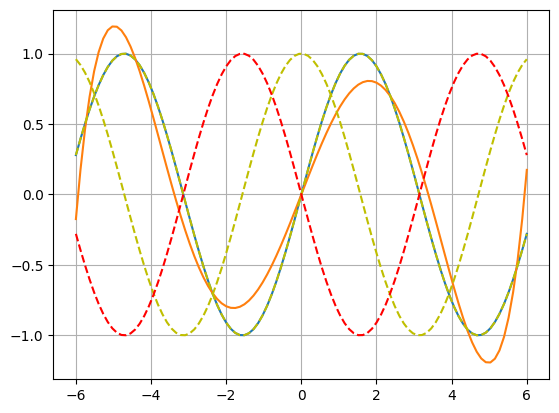

In [16]:
plt.plot(x, y)
plt.plot(x, fit_polynomial(x, y, deg=6)(x))
plt.plot(x, fit_rational_func(x, y, L=10, M=10)(x), 'y--')
plt.plot(x, fit_rational_func(x, y, L=10, M=10).deriv(axis=0, order=1)(x), 'y--')
plt.plot(x, fit_rational_func(x, y, L=10, M=10).deriv(axis=0, order=2)(x), 'r--')
plt.grid()

In [22]:
a = np.array([-1, 3, -4, 0, 0, 6])
b = np.array([1, 0, 0, 4])
polymul_ND(NDPolynomial(a).coef, NDPolynomial(b).coef), np.convolve(a, b)

(NDPolynomial(coef=array([ -1,   3,  -4,  -4,  12, -10,   0,   0,  24])),
 array([ -1,   3,  -4,  -4,  12, -10,   0,   0,  24]))

In [23]:
A = np.array([
       [ 0. ,  0. , -0.2],
       [ 0. , -1. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ]])
f_2d = NDPolynomial(A)
polymul_ND(f_2d.coef, f_2d.coef).coef

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.04],
       [ 0.  ,  0.  ,  0.  ,  0.4 ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.4 ,  0.  ,  0.  ],
       [ 0.  , -2.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

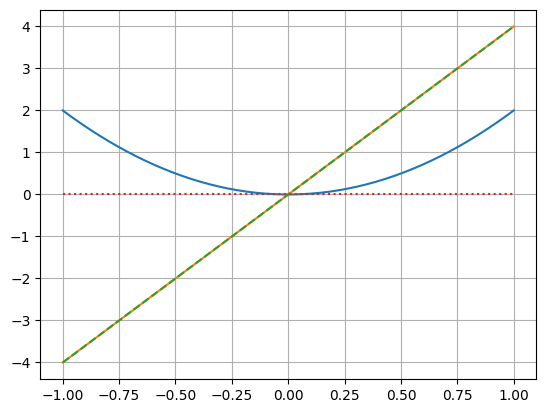

In [156]:
x = np.linspace(-1, 1)
# plt.plot(x, NDPolynomial([])(x))
# plt.plot(x, NDPolynomial([1])(x))
# plt.plot(x, NDPolynomial([0, 1])(x))
plt.plot(x, NDPolynomial([0, 0, 2])(x))
plt.plot(x, NDPolynomial([0, 4])(x))
plt.plot(x, NDPolynomial([0, 0, 2])._diff(axis=0)(x), '--')
plt.plot(x, NDPolynomial([0, 0, 2]).deriv(axis=0, order=3)(x), ':')
# plt.plot(x, NDPolynomial([0, 0, 0, 1])(x))
# plt.plot(x, NDPolynomial([0, 0, 0, 1])._diff(axis=0)(x))
# plt.ylim(-1, 1)
plt.grid()

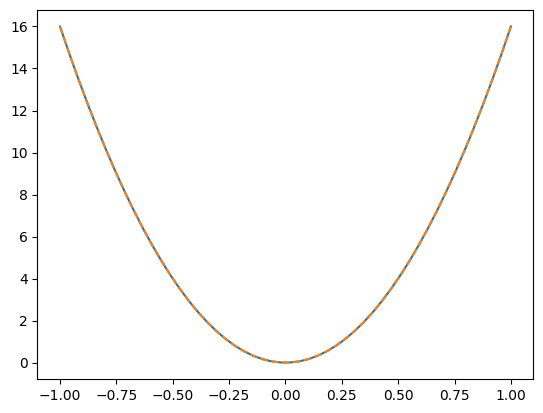

In [157]:
plt.plot(x, NDPolynomial([0, 4])(x)*NDPolynomial([0, 4])(x))
plt.plot(x, polymul_ND(NDPolynomial([0, 4]), NDPolynomial([0, 4]))(x), '--')

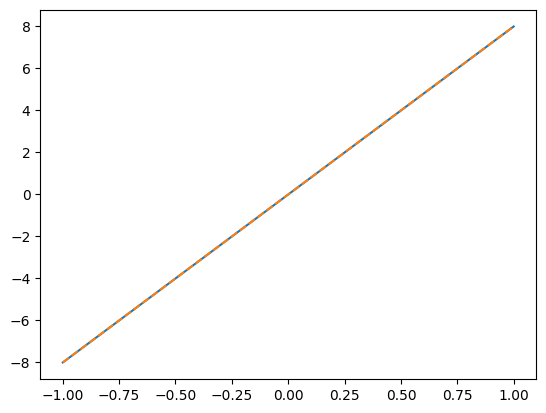

In [158]:
plt.plot(x, NDPolynomial([0, 4])(x)+NDPolynomial([0, 4])(x))
plt.plot(x, polyadd_ND(NDPolynomial([0, 4]), NDPolynomial([0, 4]))(x), '--')

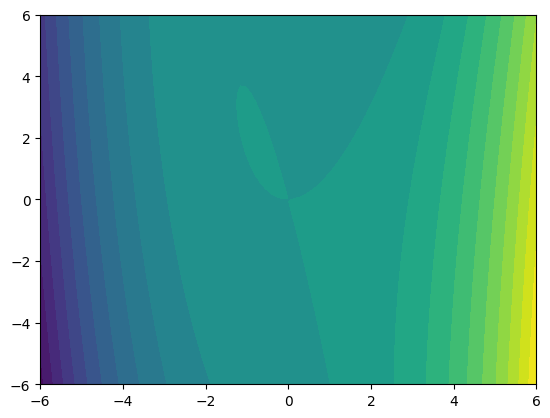

In [82]:
f = lambda x1, x2: (x1**3) - 0.2*(x2**2) - x1*x2
x1 = np.linspace(-6, 6, 100)
x2 = np.linspace(-6, 6, 100)

X1, X2 = np.meshgrid(x1, x2, indexing='ij')
plt.contourf(X1, X2, f(X1, X2), levels=20)

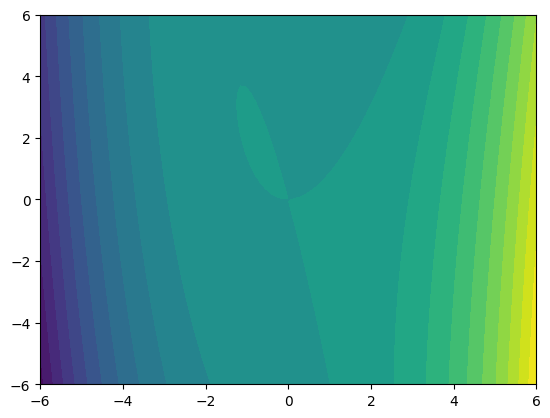

In [83]:
coef = np.zeros((6, 3))
coef[3, 0] = 1
coef[0, 2] = -0.2
coef[1, 1] = -1
# coef[5, 0] = -1

X = np.stack([X1.flatten(), X2.flatten()]).T
f_2d = NDPolynomial(coef)
plt.contourf(X1, X2, f_2d(X).reshape(100, 100), levels=20)

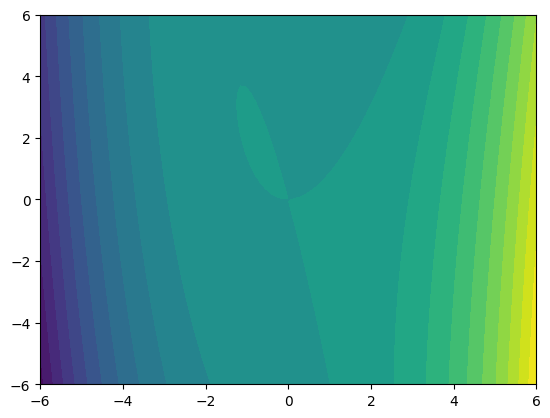

In [87]:
plt.contourf(X1, X2, fit_polynomial(X, f(X1, X2).flatten(), deg=6)(X).reshape(100, 100), levels=20)

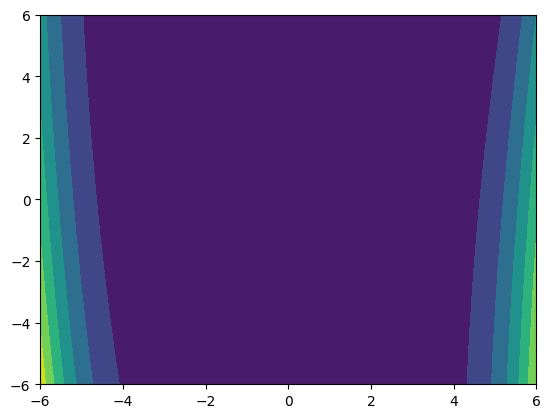

In [85]:
plt.contourf(X1, X2, f(X1, X2)*f(X1, X2))

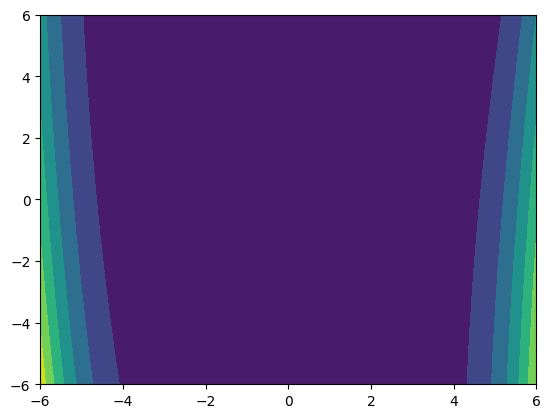

In [47]:
plt.contourf(X1, X2, (f_2d(X) * f_2d(X)).reshape(100, 100))

In [19]:
polymul_ND(f_2d, f_2d).coef

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.04],
       [ 0.  ,  0.  ,  0.  ,  0.4 ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.4 ,  0.  ,  0.  ],
       [ 0.  , -2.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

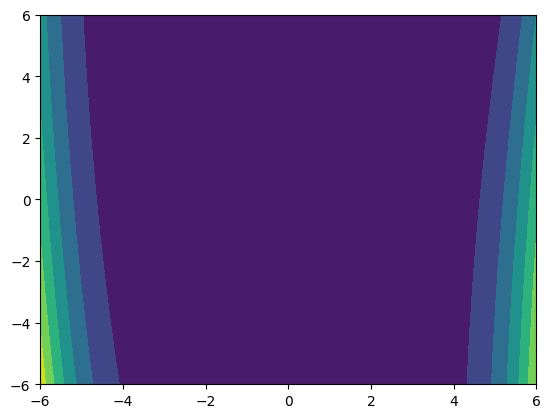

In [160]:
plt.contourf(X1, X2, polymul_ND(f_2d, f_2d)(X).reshape(100, 100))

In [165]:
np.all(polyadd_ND(f_2d, f_2d)(X) - (f_2d(X) + f_2d(X)) == 0)

True

In [9]:
# from dataclasses import dataclass

# # Utility functions
# def _as_vector(x):
#     _x = np.asarray(x)
#     if len(_x.shape) == 1:
#         _x = _x.reshape(-1, 1)
#     return _x

# def _get_degrees(deg, dims=1):
#     if type(deg) == int:
#         degrees = np.array(list(itertools.product(*(range(deg + 1), )*dims)))
#     else:
#         degrees = np.array(deg).reshape(-1, dims)
#     return degrees

# def _vandermonde(x, degrees):
#     _x = _as_vector(x)
#     return np.stack(np.prod([_x**d for d in degrees], axis=-1), axis=-1)

# @dataclass
# class NDPolynomial:
#     '''Class for representing a polynomial function of multiple variables
#     '''
#     degrees: np.ndarray
#     coeff: np.ndarray
    
#     def __init__(self, degrees, coeff):
#         self.degrees = _as_vector(degrees)
#         self.coeff = _as_vector(coeff)

#     def __call__(self, x):
#         _x = _as_vector(x)
#         if len(self.degrees) > 0:
#             return _vandermonde(_x, self.degrees) @ self.coeff
#         else:
#             return np.zeros_like(_x)
    
#     def _diff(self, axis):
#         if len(self.degrees) > 0:
#             nonzero = self.degrees[:, axis] != 0
#             deriv_degrees = np.array([[d - 1 if (i == axis) else d for i, d in enumerate(degs) if d != 0] for degs in self.degrees[nonzero]])
#             deriv_coeff = self.degrees[nonzero][:, axis] * self.coeff[nonzero].squeeze()
#             return NDPolynomial(deriv_degrees, deriv_coeff)
#             # ind = np.not_equal(np.isclose(deriv_coeff, 0), True)
#             # return NDPolynomial(deriv_degrees[ind], deriv_coeff[ind])
        
#         else:
#             return NDPolynomial([], [])

#     def deriv(self, axis, order=1):
#         deriv = self
#         for i in range(order):
#             deriv = deriv._diff(axis=axis)
#         return deriv

# @dataclass
# class RationalFunction:
#     '''Class for representing a rational function, i.e. a function which is the ratio of two polynomial:
#     f(x) = p_L(x)/q_M(x)

#     degrees_L: np.ndarray, nominator degrees
#     degrees_M: np.ndarray, denominator degrees
#     coeff_L: np.ndarray, nominator coefficients
#     coeff_M: np.ndarray, denominator coefficients
#     '''
#     degrees_L: np.ndarray
#     degrees_M: np.ndarray
#     coeff_L: np.ndarray
#     coeff_M: np.ndarray

#     def __call__(self, x):
#         return NDPolynomial(self.degrees_L, self.coeff_L)(x) / NDPolynomial(self.degrees_M, self.coeff_M)(x)

# def fit_polynomial(x, y, deg):
#     '''Returns NDPolynomial fit of x, y data.
    
#     Parameters:
#     x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
#     y: `np.ndarray` of shape (N,) where N is number of datapoints
#     deg: Either `int` or `np.ndarray`.
#         If deg is an `int`, deg is taken to be the highest degree in each variable
#         and a monomial basis for the polynomial is generated automatically.
#         Alternatively you may provide deg as an array of monomial degrees.
#         For example for 3D data (M=3), you can write: `deg = np.array([(0, 0, 0), (0, 1, 0), (0, 0, 2)])`
#         to get a function fit of the form f(x1, x2, x3) = a + b * x2 + c * x3**2
#     '''
#     _x = _as_vector(x)
#     _y = _as_vector(y)
    
#     dims = _x.shape[-1]
#     degrees = _get_degrees(deg, dims)
#     monomials = _vandermonde(_x, degrees)
#     coeff = np.linalg.lstsq(monomials, _y, rcond=None)[0]
#     return NDPolynomial(degrees, coeff)
#     # ind = np.not_equal(np.isclose(coeff, 0), True)
#     # return NDPolynomial(degrees[ind], coeff[ind])

# def fit_rational_func(x, y, L, M):
#     '''Returns RationalFunction fit of x, y data on the form f(x) = P_L(x)/Q_M(x)
#     where P_L is a polynomial of order L and Q_M is of order M.
    
#     Parameters:
#     x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
#     y: `np.ndarray` of shape (N,) where N is number of datapoints
#     L: `int`. Nominator degrees
#     M: `int`. Denominator degrees
#         L and M are taken to be the highest degrees in each variable
#         and a monomial basis for each polynomial is generated automatically.
#         The 0th order coefficient of Q_M is always taken to be 1.
#     '''
#     _x = _as_vector(x)
#     _y = _as_vector(y)

#     degrees_L = _get_degrees(L)
#     degrees_M = _get_degrees(M)
#     VL = _vandermonde(_x, degrees_L)
#     VM = _vandermonde(_x, degrees_M)
#     W = np.concatenate([VL, - _y * VM[:, 1:]], axis=1)
#     coeff_LM = np.linalg.lstsq(W, y, rcond=None)[0]
#     coeff_L = coeff_LM[:L+1]
#     coeff_M = np.concatenate([np.array([1]), coeff_LM[L+1:]])
#     return RationalFunction(degrees_L, degrees_M, coeff_L, coeff_M)
    

In [8]:
np.convolve(f_fit.coeff.squeeze(), f_fit.coeff.squeeze()).shape

NameError: name 'f_fit' is not defined

In [189]:
from numpy.polynomial.polyutils import as_series

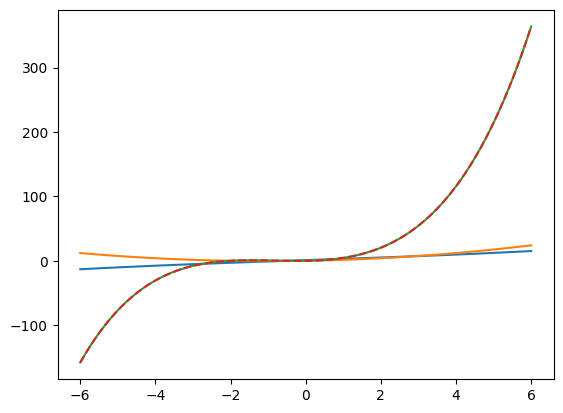

In [190]:
g_degrees = get_degrees(3)
g_coeff = [1, 2, 0, 0.01]
g = NDPolynomial(g_degrees, g_coeff)
h_degrees = get_degrees(2)
h_coeff = [0, 1, 0.5]
h = NDPolynomial(h_degrees, h_coeff)
gh = NDPolynomial(get_degrees(len(np.convolve(g.coeff.squeeze(), h.coeff.squeeze())) - 1), np.convolve(g.coeff.squeeze(), h.coeff.squeeze()))
plt.plot(x, g(x))
plt.plot(x, h(x))
plt.plot(x, gh(x), '-')
plt.plot(x, h(x)*g(x), '--')

In [175]:
gh.degrees, gh.coeff

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5]]),
 array([[0.   ],
        [1.   ],
        [2.5  ],
        [1.   ],
        [0.01 ],
        [0.005]]))

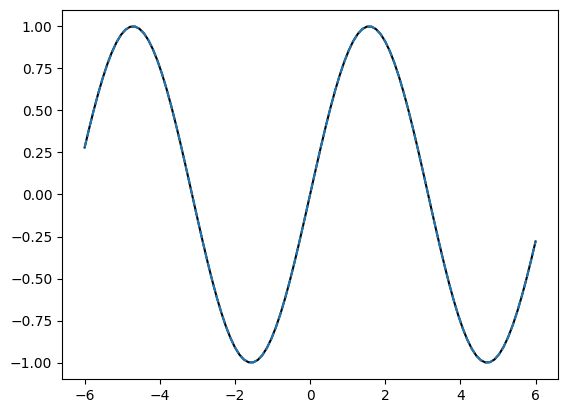

In [185]:
# f_fit = RationalFunction(get_degrees(L), get_degrees(M), L_coeff, M_coeff)
f_fit = fit_rational_func(x, y, 10, 10)
plt.plot(x, y, 'k-')
plt.plot(x, f_fit(x), '--')

(-10.0, 10.0)

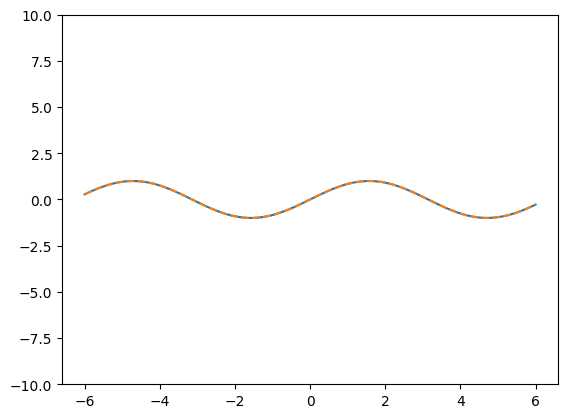

In [196]:
plt.plot(x, y)
plt.plot(x, fit_polynomial(x, y, deg=10)(x), '--')
plt.ylim(-10, 10)

In [16]:
f = lambda x1, x2: (x1**3) - 0.2*(x2**2) - x1*x2
x1 = np.linspace(-6, 6, 100)
x2 = np.linspace(-6, 6, 100)

X1, X2 = np.meshgrid(x1, x2, indexing='ij')
# fit_polynomial()
# plt.plot(X[:, 0], y, '-')
# plt.plot(X[:, 0], fit_polynomial(X, y, deg=2)(x))
# plt.ylim(-1, 1)
# plt.grid()

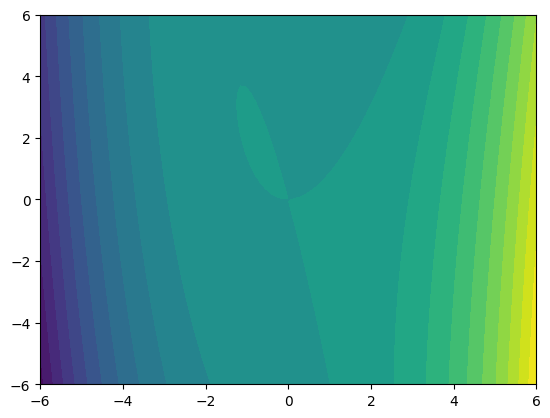

In [17]:
plt.contourf(X1, X2, f(X1, X2), levels=20)

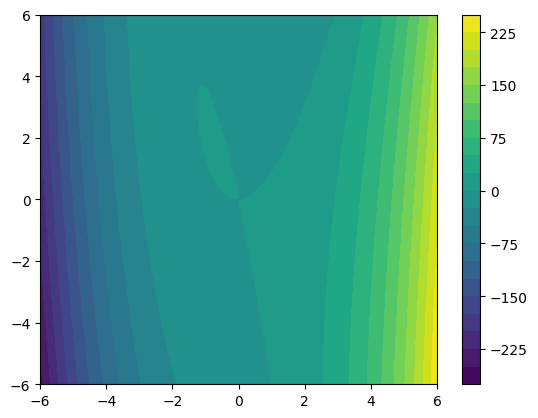

In [40]:
X = np.stack([X1.flatten(), X2.flatten()]).T
Y = f(X[:,0], X[:,1])
f_fit = fit_polynomial(X, Y, deg=3)
plt.contourf(X1, X2, f_fit(X).reshape(100, 100), levels=20)
plt.colorbar()

In [50]:
[d for d in f_fit.degrees]

[array([0, 0]),
 array([0, 1]),
 array([0, 2]),
 array([0, 3]),
 array([1, 0]),
 array([1, 1]),
 array([1, 2]),
 array([1, 3]),
 array([2, 0]),
 array([2, 1]),
 array([2, 2]),
 array([2, 3]),
 array([3, 0]),
 array([3, 1]),
 array([3, 2]),
 array([3, 3])]

In [83]:
f_fit.degrees.shape

(16, 2)

In [82]:
f_fit.coeff.shape

(16, 1)

In [63]:
np.array([[1, 2]]).shape

(1, 2)

In [80]:
get_degrees(deg=2, dims=2)

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [86]:
_vandermonde(np.array([[2, 3]]), degrees=get_degrees(3, dims=2)).shape

(1, 16)

In [77]:
np.outer(_vandermonde(2, degrees=get_degrees(3, dims=1)), _vandermonde(3, degrees=get_degrees(3, dims=1)))

array([[  1,   3,   9,  27],
       [  2,   6,  18,  54],
       [  4,  12,  36, 108],
       [  8,  24,  72, 216]])

In [62]:
np.outer(X[:, 0], X[:, 1]).shape

(10000, 10000)

In [ ]:
_vandermonde(X, degrees=get_degrees(3, dims=2))

In [55]:
np.stack(np.prod([[1, 2]**d for d in f_fit.degrees], axis=-1), axis=-1).shape

(16,)